
<div style="text-align: center;">
  <div style="display: flex; justify-content: center;">
    <img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRQHBG_JmpOhUxcbMLkJlZcrmEWNDLjJb1ufK7peaaJPPmDBiYBeAhIplBT-X3efpIAN5g&usqp=CAU" alt="IPL Data Analysis In Databricks Using PySpark" style="margin-bottom: 10px; width: 200px;">
  </div>
  <h2 style="margin-top: 0;">IPL Data Analysis In Databricks Using PySpark</h2>
</div>


In [0]:
from pyspark.sql.window import Window
from pyspark.sql.functions import count, col, sum, max, min, dense_rank, row_number, expr, when
import matplotlib.pyplot as plt 

In [0]:
ball_by_ball_path = "dbfs:/FileStore/tables/IPL/IPL_Ball_by_Ball_2008_2022.csv"
matches_path = "dbfs:/FileStore/tables/IPL/IPL_Matches_2008_2022.csv"

ball_by_ball = spark.read.csv(ball_by_ball_path, header=True, inferSchema= True)
matches = spark.read.csv(matches_path, header=True, inferSchema= True)

join_df = ball_by_ball.join(matches, on="ID", how="INNER")


#### 1.Find out max and min wicket taken by a bowler in each season ?

In [0]:

def wickets_sum():
    return(ball_by_ball.join(matches, on="ID", how="INNER").
                select("Season", "bowler","isWicketDelivery").
                filter(col("isWicketDelivery") == 1).
                groupBy("Season","bowler").
                agg(sum(col("isWicketDelivery")).alias("total_wickets"))
    )

def max_wickets_taken_each_season():

    max_wickets = (wickets_sum().groupBy("Season","bowler").
                agg(max(col("total_wickets")).alias("wickets")).
                orderBy(col("Season").desc(),col("wickets").desc())
                )

    # defin window specification for identifying max wicket taken by a bowler in each season

    max_windowspec = Window.partitionBy(col("Season")).orderBy(col("wickets").desc())

    return(display(max_wickets.withColumn("rank", dense_rank().over(max_windowspec)).filter(col("rank") == 1)))

def min_wickets_taken_each_season():
    min_wickets = (wickets_sum().groupBy("Season","bowler").
                agg(min(col("total_wickets")).alias("wickets")).
                orderBy(col("Season").desc(),col("wickets").desc())
                )
    # defin window specification for identifying min wicket taking bowler in each season

    min_windowspec = Window.partitionBy(col("Season")).orderBy(col("wickets"))

    return((min_wickets.withColumn("rank", dense_rank().over(min_windowspec)).filter(col("rank") == 1)))

#### 2.Find out bowler taken wicket of same player more than once in same season or diff season?

In [0]:
def wicket_pair():
    wicket_pair = (join_df.
                filter(col("isWicketDelivery") == 1).
                select("batter", "bowler").
                groupBy(col("bowler"), col("batter")).count()
    )
    
    return (wicket_pair.filter(col("count") > 1).orderBy(col("count")))


#### 3.Find out which bowler has given max and min runs in a season?

In [0]:
def max_runs_given():
    # For max runs given
    max_runs_given = (join_df.select("Season","bowler","total_run").
                    groupBy(col("Season"),col("bowler")).
                    agg(sum(col("total_run")).alias("total_runs")).
                    orderBy(col("Season").desc(), col("total_runs").desc())
    )

    # define window specification for identifying max runs in each eason
    max_runs_windowspec = Window.partitionBy(col("Season")).orderBy(col("total_runs").desc())
    return(max_runs_given.withColumn("rank", dense_rank().over(max_runs_windowspec)).filter(col("rank") == 1))

def min_runs_given():
    # For min runs given
    min_runs_given = (join_df.select("Season","bowler","total_run").
                    groupBy(col("Season"),col("bowler")).
                    agg(sum(col("total_run")).alias("total_runs")).
                    orderBy(col("Season").desc(), col("total_runs"))
    )

    # define window specification for identifying min runs in each eason
    min_runs_windowspec = Window.partitionBy(col("Season")).orderBy(col("total_runs"))
    return(min_runs_given.withColumn("rank", dense_rank().over(min_runs_windowspec)).filter(col("rank") == 1))


#### 4.Find out which bowler has given max boundary runs in each season?

In [0]:
def bowler_given_max_boundary_runs():

    bowler_given_max_boundary_runs = (join_df.filter(col("non_boundary") != 0).
                                    select("Season", "bowler", "total_run").
                                    groupBy(col("bowler"), col("Season")).
                                    agg(sum(col("total_run")).alias("max_run_given"))
    )

    return(bowler_given_max_boundary_runs)


#### 5.Find out which bowler has taken max wicket against each team?

In [0]:
def max_wicket_against_each_team():

    total_wicket_against_team = (join_df.filter(col("isWicketDelivery") == 1).
                            select("Team1", "Team2", "bowler", "BattingTeam", "isWicketDelivery").
                            groupBy(col("bowler"), col("BattingTeam")).
                            agg(sum(col("isWicketDelivery")).alias("total_wicket"))
    )
    # define window specification for identifying max wickets taken by a bowler based on rank
    max_wicket_windowspec = Window.partitionBy(col("BattingTeam")).orderBy(col("total_wicket").desc())

    return(total_wicket_against_team.withColumn("rank", dense_rank().
                            over(max_wicket_windowspec)).filter(col("rank") == 1)
    )

#### 6.Find out which team went into finals most of the times?

In [0]:
# We will find how many times a team went into finals as Team1.
team1_into_finals = (matches.filter(col("MatchNumber") == "Final").
                    groupBy(col("Team1").alias("Team")).
                    agg(count(col("Team1")).alias("count_of_team1"))
)

# We will find how many times a team went into finals as Team2.
team2_into_finals = (matches.filter(col("MatchNumber") == "Final").
                    groupBy(col("Team2").alias("Team")).
                    agg(count(col("Team2")).alias("count_of_team2"))
)

def team_into_finals():

        col_to_sum = ["count_of_team1", "count_of_team2"]      

        team_into_finals = (team1_into_finals.join(team2_into_finals, on="Team", how="INNER")
        )

        return(team_into_finals.withColumn("no_of_times_into_finals", expr('+'.join(col_to_sum))).
                select("Team","no_of_times_into_finals").
                orderBy(col("no_of_times_into_finals").desc())
                )


#### 7.Find out how many times teams have won IPL?

In [0]:
# We will find how many times a team went into finals and won as Team1.
team1_into_finals_and_won = (matches.filter(col("MatchNumber") == "Final").
                withColumn("Team_equals_winning_team", when(col("Team1") == col("WinningTeam"), col("Team1"))).
                groupBy(col("Team1").alias("Team")).
                agg(count(col("Team_equals_winning_team")).alias("count_of_team1"))
)

# We will find how many times a team went into finals and won as Team2.
team2_into_finals_and_won = (matches.filter(col("MatchNumber") == "Final").
                withColumn("Team_equals_winning_team", when(col("Team2") == col("WinningTeam"), col("Team2"))).
                groupBy(col("Team2").alias("Team")).
                agg(count(col("Team_equals_winning_team")).alias("count_of_team2"))
)

def team_into_finals_and_won():

        col_to_sum = ["count_of_team1", "count_of_team2"]

        team_into_finals_and_won = (team1_into_finals_and_won.join(team2_into_finals_and_won, on="Team", how="INNER")
        )

        return(team_into_finals_and_won.withColumn("no_of_times_into_finals", expr('+'.join(col_to_sum))).
                select("Team","no_of_times_into_finals").
                orderBy(col("no_of_times_into_finals").desc())
                )


#### 8.Find out the if a team wins a toss and choose to bat do they win the match also?

In [0]:
def team_won_toss_and_chose_to_bat():

        team_won_toss_and_chose_to_bat = (join_df.filter(col("TossDecision") == "bat").
                withColumn("Team_equals_TossWinner",
                when((col("Team1") == col("TossWinner")) & (col("Team1") == col("WinningTeam")) , col("Team1")).
                when((col("Team2") == col("TossWinner")) & (col("Team2") == col("WinningTeam")), col("Team2"))
                )
        )

        return(team_won_toss_and_chose_to_bat.filter(col("Team_equals_TossWinner").isNotNull()).
                select("Season","Team1","Team2","TossWinner","WinningTeam", "TossDecision").
                distinct()
                )


#### 9.Find out city/venue where max and min matches where played in each season?

In [0]:
def city_with_max_matches():

    city_with_max_matches = (matches.groupBy(col("Season"),col("Venue")).
                            agg(count(col("Venue")).alias("no_of_matches")).
                            orderBy(col("no_of_matches").desc()))

    return(city_with_max_matches)


#### 10.Find the strongest and weakest teams based on match wins?

In [0]:

team_won_season_wise = (matches.groupBy(col("Season"), col("WinningTeam")).
                            agg(count(col("WinningTeam")).alias("no_of_matches_won")).
                            orderBy(col("Season").desc(), col("no_of_matches_won").desc())
)

teams_won = (matches.groupBy(col("WinningTeam")).
            agg(count(col("WinningTeam")).alias("no_of_matches_won")).
            filter(col("WinningTeam") != "NA")
)

def strongest_team_season_wise():
    team_won_season_wise_windowspec = Window.partitionBy("Season").orderBy(col("no_of_matches_won").desc())

    strongest_team_season_wise = (team_won_season_wise.withColumn("rank", dense_rank().
                                over(team_won_season_wise_windowspec)).filter(col("rank") == 1))

    return(strongest_team_season_wise.select("Season",col("WinningTeam").alias("Strongest_Team"),"no_of_matches_won").
        orderBy(col("Season").desc()))


def weakest_team_season_wise():
    team_won_season_wise_windowspec = Window.partitionBy("Season").orderBy(col("no_of_matches_won"))

    weakest_team_season_wise = (team_won_season_wise.withColumn("rank", dense_rank().
                                over(team_won_season_wise_windowspec)).filter(col("rank") == 1))

    return(weakest_team_season_wise.select("Season",col("WinningTeam").alias("Weakest_Team"),"no_of_matches_won").orderBy(col("Season").desc()))

def strongest_team():
    return (teams_won.orderBy(col("no_of_matches_won").desc()).limit(5))

def weakest_team():
    return (teams_won.orderBy(col("no_of_matches_won")).limit(5))



#### 11.Find matches per season and plot them as a bar chart?

Out[13]: Text(0.5, 1.0, 'Matches Per Season')

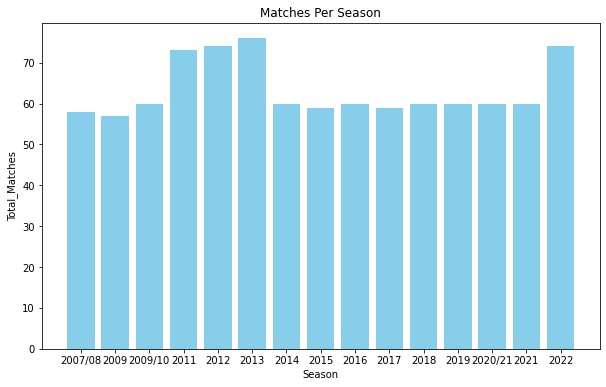

In [0]:

matches_per_season = (matches.groupBy("Season").agg(count("ID").alias("Total_Matches")).orderBy("Season"))

pd_df = matches_per_season.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(pd_df['Season'], pd_df['Total_Matches'], color = 'SkyBlue')
plt.xlabel('Season')
plt.ylabel('Total_Matches')
plt.title('Matches Per Season')


#### 12.Visualize most final matches played by a team?

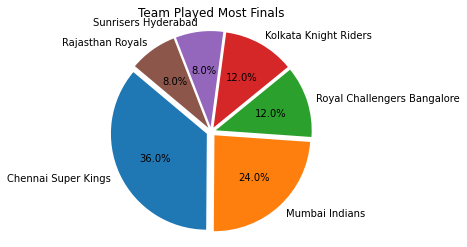

In [0]:
result_pd = team_into_finals().toPandas()
explode = (0.05,0.05,0.05,0.05,0.05,0.05)
plt.figure(figsize=(4,4))
plt.pie(result_pd['no_of_times_into_finals'], labels=result_pd['Team'], autopct='%1.1f%%', startangle=140, explode=explode)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Team Played Most Finals')
plt.show()


#### 13.Find out who hit the most boundaries?

In [0]:
def batter_hit_most_boundaries():

    batter_hit_most_boundaries = (join_df.filter(col("non_boundary") == 1).
                                select("batter").
                                groupBy("batter").
                                agg(count(col("batter")).alias("no_of_boundaries")).
                                orderBy(col("no_of_boundaries").desc()).limit(1)
    )

    return(batter_hit_most_boundaries)


#### 14.Who won most man of the matches?

In [0]:
def most_player_of_the_match():
    player_of_the_match = (matches.select("Player_of_Match").groupBy(col("Player_of_Match")).
                           agg(count(col("Player_of_Match")).alias("no_of_times_won")).
                           orderBy(col("no_of_times_won").desc()).limit(1)
    )
    return(player_of_the_match)

display(most_player_of_the_match())

Player_of_Match,no_of_times_won
AB de Villiers,25



#### 15.Bowler who bowled most no of dot balls?

In [0]:
def bowler_bowled_most_dot_balls():
    bowler_bowled_most_dot_balls = (ball_by_ball.filter(col("total_run") == 0).
                                    select("bowler","ballnumber").
                                    groupBy(col("bowler")).
                                    agg(count(col("ballnumber")).alias("no_of_dot_balls")).
                                    orderBy(col("no_of_dot_balls").desc()).limit(1)
    )
    return(bowler_bowled_most_dot_balls)

display(bowler_bowled_most_dot_balls())

bowler,no_of_dot_balls
B Kumar,1385
